<a href="https://colab.research.google.com/github/hopesofbuzzy/URFU_adii/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B8/5/%D0%92%D0%B8%D0%B7%D1%83%D0%B0%D0%BB%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [ ]:
from google.colab import files #to upload files Для загрузки файлов, не менять

files.upload()

# Часть 1

In [4]:
# df = pd.read_excel('dataset.xlsx', sheet_name='А7_оса_1')

In [162]:
def calculate_median_ci(data):
    """
    Расчет медианы и 95% доверительного интервала для медианы
    """
    n = len(data)
    # print('n = ',n)
    if n == 0:
        return np.nan, (np.nan, np.nan)

    # Сортируем данные
    sorted_data = np.sort(data)

    # Вычисляем параметр k
    k = int(np.floor(n/2 - 1.96 * np.sqrt(n)/2))
    k = max(0, k)  # k не может быть отрицательным

    # Вычисляем границы доверительного интервала
    lower_idx = k
    upper_idx = n - k - 1  # -1 потому что индексы с 0
    # print('lower_idx = ', lower_idx, 'upper_idx = ', upper_idx)

    median = np.median(data)
    lower_ci = sorted_data[lower_idx]
    upper_ci = sorted_data[upper_idx]

    return median, (lower_ci, upper_ci)

In [6]:
def calculate_mean_ci(data):
    """
    Расчет среднего и 95% доверительного интервала для среднего
    """
    n = len(data)
    if n == 0:
        return np.nan, (np.nan, np.nan)

    # Вычисляем среднее
    mean = np.mean(data)

    # Вычисляем стандартную ошибку среднего
    sem = stats.sem(data)

    # Вычисляем 95% доверительный интервал using t-distribution
    ci = stats.t.interval(0.95, df=n-1, loc=mean, scale=sem)

    return mean, ci

In [140]:
import string

def floatn(s):
  """
    Форматирование входных данных ячейки таблицы в float
  """
  if not str(s)[0] in string.digits + '-':
    return 0.0
  else:
    return float(s)

In [173]:
# Дополнительная функция для создания сводной таблицы
def create_summary_table(file_path: str, sheet_name: str, results={}):
    """
    Создание сводной таблицы с результатами
    """
    df = pd.read_excel(file_path, sheet_name)
    groups_names = {0: 'Пациенты с АГ и МФА', 1: 'Пациенты с АГ и МФА + ИИ'}
    group_col_name = df.columns[0]  # сохраняем название колонки
    # map - использует введённое в dict обозначение для всех элементов столбца Инсульт
    df[group_col_name] = df[group_col_name].map(groups_names)

    group_col = df.columns[0]
    indicators = df.columns[1:]
    # Получаем все группы из первого столбца
    groups = sorted(df[group_col].unique())

    summary_data = []

    for indicator in indicators:
      if indicator in results or not results:
        for group in groups:
            if group in results.get(indicator) or not results:
                # data = results[indicator][group]
                data = list(map(floatn, list(df[df[group_col] == group][indicator])))
                median, ci = calculate_median_ci(data)
                summary_data.append({
                    'Показатель': indicator,
                    'Группа': group,
                    'n': len(data), # data['n'],
                    'Медиана': f"{median:.2f}",
                    '95% ДИ нижняя': f"{ci[0]:.2f}",
                    '95% ДИ верхняя': f"{ci[1]:.2f}",
                    'ДИ': f"[{ci[0]:.2f}; {ci[1]:.2f}]"
                })

    summary_df = pd.DataFrame(summary_data)
    #summary_df.to_excel('clinical_study_summary.xlsx', index=False)
    #print("Сводная таблица сохранена как 'clinical_study_summary.xlsx'")
    return summary_df

In [174]:
results = {
    'PSV': ['Пациенты с АГ и МФА'],
    'PI': ['Пациенты с АГ и МФА']
}
create_summary_table('dataset.xlsx', 'Лист2', results=results)


,Показатель,Группа,n,Медиана,95% ДИ нижняя,95% ДИ верхняя,ДИ
0,PSV,Пациенты с АГ и МФА,18,78.50,74.00,82.00,[74.00; 82.00]
1,PI,Пациенты с АГ и МФА,18,1.60,1.40,2.00,[1.40; 2.00]


# Часть 2

In [ ]:
def wrap_labels(labels, width=12):
    """Переносит длинные подписи по словам"""
    wrapped_labels = []
    for label in labels:
        words = str(label).split()
        lines = []
        current_line = []
        for word in words:
            if len(' '.join(current_line + [word])) <= width:
                current_line.append(word)
            else:
                if current_line:
                    lines.append(' '.join(current_line))
                current_line = [word]
        if current_line:
            lines.append(' '.join(current_line))
        wrapped_labels.append('\n'.join(lines))
    return wrapped_labels

In [ ]:
def create_grouped_bar_chart(results, groups, indicators, pvalues = None):

    """
    Создание сгруппированной столбчатой диаграммы
    """
    n_indicators = len(indicators)
    n_groups = len(groups)

    # Настройка графика
    fig, ax = plt.subplots(figsize=(max(8, n_indicators * 1.4), 8))

    # Цвета для групп
    #colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'][:n_groups]
    #colors = ['#ffb6c1', '#0060a0'][:n_groups]#{1: 'Основная', 2: 'Контрольная'}
    #colors = ['#003366', '#48D1CC'][:n_groups]# groups_names = {1: 'Группа комбинированной терапии', 0: 'Группа стандартной терапии'}
    colors = ['#2ca02c', '#d62728'][:n_groups]#{1: 'Подгруппа 1a', 2: 'Подгруппа 1b'}
    #colors = ['#9467bd', '#8c564b'][:n_groups]#{3: 'Подгруппа 2a', 4: 'Подгруппа 2b'}
    #colors = ['#DC143C', '#87CEEB'] # {0: 'Пациенты с АГ и МФА', 1: 'Пациенты с АГ и МФА + ИИ'}
    #colors = ['#6699CC', '#F4A460'] #До и после для листа 8
    #colors = ['#0066FF', '#FFFF00'] #До и после для листа 7

    # Ширина столбцов и позиции
    bar_width = 0.8 / n_groups
    x_pos = np.arange(n_indicators)

    # Создаем столбцы для каждой группы
    for i, group in enumerate(groups):
        medians = []
        ci_lower_errors = []
        ci_upper_errors = []

        for indicator in indicators:
            if group in results[indicator]:
                data = results[indicator][group]
                medians.append(data['median'])
                # Для ошибок: нижняя ошибка = медиана - нижняя граница ДИ
                # верхняя ошибка = верхняя граница ДИ - медиана
                lower_error = data['median'] - data['ci_lower']
                upper_error = data['ci_upper'] - data['median']
                ci_lower_errors.append(lower_error)
                ci_upper_errors.append(upper_error)
            else:
                medians.append(0)
                ci_lower_errors.append(0)
                ci_upper_errors.append(0)

        # Позиции для текущей группы
        positions = x_pos + i * bar_width - (n_groups - 1) * bar_width / 2

        #min_height_in_group = min(medians) if medians else 0
        #common_label_height = min_height_in_group * 0.6

        # Столбцы с ошибками
        bars = ax.bar(positions, medians, bar_width,
                     label=f' {group}', color=colors[i],
                     yerr=[ci_lower_errors, ci_upper_errors],
                     capsize=5, error_kw={'elinewidth': 2, 'markeredgewidth': 2})
        for bar, median in zip(bars, medians):
            height = bar.get_height()
        #    ax.text(bar.get_x() + bar.get_width()/2., height/2, #common_label_height
        #           f'{median:.0f}', ha='center', va='center',
        #           fontweight='bold', color='#000080', fontsize=16)

        # Добавляем p-value над каждой группой столбцов
        if pvalues:
            # Находим общий максимум по всем данным для установки верхнего предела
            all_max = 0
            for indicator in indicators:
                for group in groups:
                    if group in results[indicator]:
                        data = results[indicator][group]
                        if data['ci_upper'] > all_max:
                            all_max = data['ci_upper']

            for i, indicator in enumerate(indicators):
                if indicator in pvalues:
                    # Находим максимальную высоту среди всех столбцов для этого показателя
                    max_height = 0
                    for group in groups:
                        if group in results[indicator]:
                            data = results[indicator][group]
                            height = data['ci_upper']
                            if height > max_height:
                                max_height = height

                    # Вычисляем позицию для p-value - над самым высоким столбцом, но не выходя за границы
                    text_height = min(max_height + 0.05 * all_max, all_max * 1.05)

                    # Добавляем текст p-value
                    p_data = pvalues[indicator]
                    p_text = p_data[0]  # текст p-value
                    p_style = p_data[1] # флаг стиля
                    x_position = x_pos[i]
                    if p_style == 1:
                        text_props = {'color': 'red', 'fontweight': 'bold', 'fontsize': 15}
                    else:
                        text_props = {'color': 'black', 'fontweight': 'normal', 'fontsize': 14}
                    ax.text(x_position, text_height,
                          p_text,
                          ha='center', va='bottom', **text_props)

            # Немного расширяем верхнюю границу графика чтобы вместить p-value
            ax.set_ylim(top=all_max * 1.15)

    # Настройка внешнего вида
    #ax.set_xlabel(' ', fontsize=16, fontweight='bold')
    #ax.set_xlabel('Скоростные показатели ОСА, см/с', fontsize=16, fontweight='bold')
    #ax.set_xlabel('Индексы резистивности ОСА', fontsize=16, fontweight='bold')

    ax.set_ylabel('Балл', fontsize=16, fontweight='bold')
    #ax.set_ylabel('см/с', fontsize=16, fontweight='bold')
    #ax.set_ylabel('ммоль/л', fontsize=16, fontweight='bold')
    #ax.set_ylabel('Медиана с 95% ДИ', fontsize=16, fontweight='bold')
    #ax.set_title('Локальные показатели гемостаза', fontsize=14, fontweight='bold')
    #ax.set_title('Показатели липидного спектра', fontsize=14, fontweight='bold')
    #ax.set_title('Общая сонная артерия', fontsize=14, fontweight='bold')
    #ax.set_title('Внутренняя сонная артерия', fontsize=14, fontweight='bold')
    #ax.set_title('Средняя мозговая артерия', fontsize=14, fontweight='bold')
    #ax.set_title('Позвоночная артерия', fontsize=14, fontweight='bold')
    ax.set_xticks(x_pos)
    wrapped_indicators = wrap_labels(indicators)
    ax.set_xticklabels(wrapped_indicators, rotation=0, ha='center')  # убрал наклон
    #ax.set_xticklabels(indicators, rotation=0, ha='right')
    ax.legend(fontsize=16)
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    # Сохраняем график
    #plt.savefig('clinical_study_results.png', dpi=300, bbox_inches='tight')
    #print("\nГрафик сохранен как 'clinical_study_results.png'")


In [ ]:
def analyze_clinical_data(file_path, sheet_name):
    """
    Основная функция для анализа клинических данных
    """
    # Чтение данных
    df = pd.read_excel(file_path, sheet_name)
    #groups_names = {1: 'Группа 1', 2: 'Группа 2'}
    groups_names = {1: 'Подгруппа 1a', 2: 'Подгруппа 1b'}
    #groups_names = {3: 'Подгруппа 2a', 4: 'Подгруппа 2b'}
    #groups_names = {3: 'Подгруппа 1a', 4: 'Подгруппа 1b'}
    #groups_names = {1: 'Группа комбинированной терапии', 0: 'Группа стандартной терапии'}
    #groups_names = {1: 'Основная', 2: 'Контрольная'}
    #groups_names = {0: 'Пациенты с АГ и МФА', 1: 'Пациенты с АГ и МФА + ИИ'}
    #groups_names = {0: 'Исходно', 1: 'Через 12 месяцев'}
    group_col_name = df.columns[0]  # сохраняем название колонки
    df[group_col_name] = df[group_col_name].map(groups_names)
    print("Типы данных в колонках:")
    print(df.dtypes)

    # Проверяем структуру данных
    print("Структура данных:")
    print(df.head())
    print("\nКолонки:", df.columns.tolist())

    # Извлекаем группы и показатели
    group_col = df.columns[0]  # Первая колонка - группы
    indicators = df.columns[1:]  # Остальные колонки - показатели

    groups = df[group_col].unique()
    groups.sort()

    print(f"\nНайдены группы: {groups}")
    print(f"Показатели: {list(indicators)}")

    # Создаем структуру для хранения результатов
    results = {}

    # Анализируем каждый показатель
    for indicator in indicators:
        results[indicator] = {}
        print(f"\n--- Анализ показателя: {indicator} ---")

        for group in groups:
            group_data = df[df[group_col] == group][indicator].dropna()

            if len(group_data) > 0:
                #median, ci = calculate_median_ci(group_data)
                median, ci = calculate_mean_ci(group_data)#Назвали median, хотя считаем среднее, чтобы не менять название переменной
                results[indicator][group] = {
                    'median': median,
                    'ci_lower': ci[0],
                    'ci_upper': ci[1],
                    'n': len(group_data)
                }

                print(f"Группа {group}: n={len(group_data)}, "
                      f"Медиана={median:.2f}, "
                      f"95% ДИ=[{ci[0]:.2f}, {ci[1]:.2f}]")
            else:
                results[indicator][group] = {
                    'median': np.nan,
                    'ci_lower': np.nan,
                    'ci_upper': np.nan,
                    'n': 0
                }
                print(f"Группа {group}: нет данных")

    # Визуализация
    #pvalues = {'PSV': ['p = 0,030', 1], 'EDV': ['p = 0,040', 1], 'TAV': ['p = 0,002', 1]}#А7_оса_1
    #pvalues = {'RI': ['p < 0,001', 1], 'PI': ['p = 0,005', 1]}##А7_оса_2
    #pvalues = {'PSV': ['p = 0,288', 0], 'EDV': ['p = 0,006', 1], 'TAV': ['p = 0,028', 1]}#А7_вса_1
    #pvalues = {'RI': ['p < 0,001', 1], 'PI': ['p = 0,017', 1]}##А7_вса_2
    #pvalues = {'PSV': ['p = 0,676', 0], 'EDV': ['p = 0,408', 0], 'TAV': ['p = 0,010', 1]}#А7_сма_1
    #pvalues = {'RI': ['p < 0,001', 1], 'PI': ['p = 0,021', 1]}##А7_сма_2
    #pvalues = {'PSV': ['p = 0,092', 0], 'EDV': ['p = 0,026', 1], 'TAV': ['p = 0,265', 0]}#А7_па_1
    #pvalues = {'RI': ['p = 0,034', 1], 'PI': ['p = 0,004', 1]}##А7_па_2

    ##pvalues = {'PSV': ['p = 0,925', 0], 'EDV': ['p = 0,024', 1], 'TAV': ['p = 0,007', 1]}#А8_оса_1
    ##pvalues = {'RI': ['p = 0,793', 0], 'PI': ['p = 0,026', 1]}##А8_оса_2
    ##pvalues = {'PSV': ['p = 0,776', 0], 'EDV': ['p = 0,012', 1], 'TAV': ['p = 0,012', 1]}#А8_вса_1
    ##pvalues = {'RI': ['p = 0,073', 0], 'PI': ['p = 0,017', 1]}##А8_вса_2
    ##pvalues = {'PSV': ['p = 0,861', 0], 'EDV': ['p = 0,163', 0], 'TAV': ['p = 0,482', 0]}#Лист2_1
    ##pvalues = {'RI': ['p = 0,756', 0], 'PI': ['p = 0,492', 0]}#Лист2_2
    ##pvalues = {'МНО y.e.' : ['p = 0.409', 0],  'Фибриноген г/л' : ['p = 0.008', 1], 'Д-димер мкг/мл' : ['p = 0.001', 1]}#A2_1
    ##pvalues = {'ПТИ %': ['p = 0,658', 0], 'АЧТВ сек' : ['p = 0.147', 0], 'АТ III %' : ['p = 0.297', 0]}#A2_2
    ##pvalues = {'ОХС': ['p = 0,015', 1], 'ХС ЛНП': ['p = 0,068', 0], 'ХС ЛВП' : ['p = 0.519', 0],	'ТГ' : ['p = 0.236', 0], 'ХС неЛВП' : ['p = 0.790', 0]}#A3
    ##pvalues = {'ОХС': ['p = 0,045', 1], 'ХС ЛНП': ['p = 0,031', 1], 'ХС ЛВП' : ['p = 0.641', 0],	'ТГ' : ['p = 0.802', 0], 'ХС неЛВП' : ['p = 0.028', 1]}#A3.1
    #pvalues = {'СРБ (мг/л)': ['p < 0,001', 1], 'ИЛ-6 (пг/л)': ['p = 0,003', 1]}#А5
    #pvalues = {'СРБ (мг/л)': ['p < 0,001', 1], 'ИЛ-6 (пг/л)': ['p < 0,001', 1]}#А51
    pvalues = {'РF': [' ', 0], 'RP': ['p < 0,001', 1],  'BP': ['p = 0,025', 1], 'GH': [' ', 0],
               'VT': [' ', 0], 'SF': [' ', 0], 'RE': ['p = 0,019', 1], 'MH': [' ', 0], 'PCS': ['p < 0,001', 1], 'MCS': [' ', 0]}
    #pvalues = {'РF': ['p < 0,001', 1], 'RP': ['p < 0,001', 1],  'BP': [' ', 0], 'GH': ['p < 0,001', 1],
    #           'VT': ['p = 0,004', 1], 'SF': [' ', 0], 'RE': ['p = 0,002', 1], 'MH': ['p < 0,001', 1], 'PCS': ['p < 0,001', 1], 'MCS': ['p = 0,002', 1]}
    #pvalues = {'Вена Розенталя': ['p < 0,001', 1], 'Внутренняя яремная вена': ['p = 0,012', 1], 'Позвоночная вена': ['p < 0,001', 1]}
    #pvalues = {'Вена Розенталя': ['p = 0,107', 0], 'Внутренняя яремная вена': ['p = 0,531', 0], 'Позвоночная вена': ['p = 0,257', 0]}

    create_grouped_bar_chart(results, groups, indicators, pvalues=pvalues)

    return results

Типы данных в колонках:
Подгруппы     object
РF             int64
RP             int64
BP           float64
GH           float64
VT           float64
SF           float64
RE           float64
MH           float64
PCS          float64
MCS          float64
dtype: object
Структура данных:
      Подгруппы  РF    RP     BP    GH    VT     SF     RE    MH   PCS   MCS
0  Подгруппа 1a   95  100  100.0  77.0  85.0  100.0  100.0  80.0  56.3  55.7
1  Подгруппа 1a   80  100  100.0  57.0  65.0  100.0  100.0  68.0  52.3  51.9
2  Подгруппа 1a   90  100  100.0  52.0  75.0  100.0  100.0  76.0  52.7  54.2
3  Подгруппа 1a   90  100  100.0  57.0  65.0  100.0  100.0  76.0  53.2  53.1
4  Подгруппа 1a  100  100  100.0  67.0  75.0  100.0  100.0  84.0  55.4  55.3

Колонки: ['Подгруппы', 'РF ', 'RP', 'BP', 'GH', 'VT', 'SF', 'RE', 'MH', 'PCS', 'MCS']

Найдены группы: ['Подгруппа 1a' 'Подгруппа 1b']
Показатели: ['РF ', 'RP', 'BP', 'GH', 'VT', 'SF', 'RE', 'MH', 'PCS', 'MCS']

--- Анализ показателя: РF  ---
Группа 

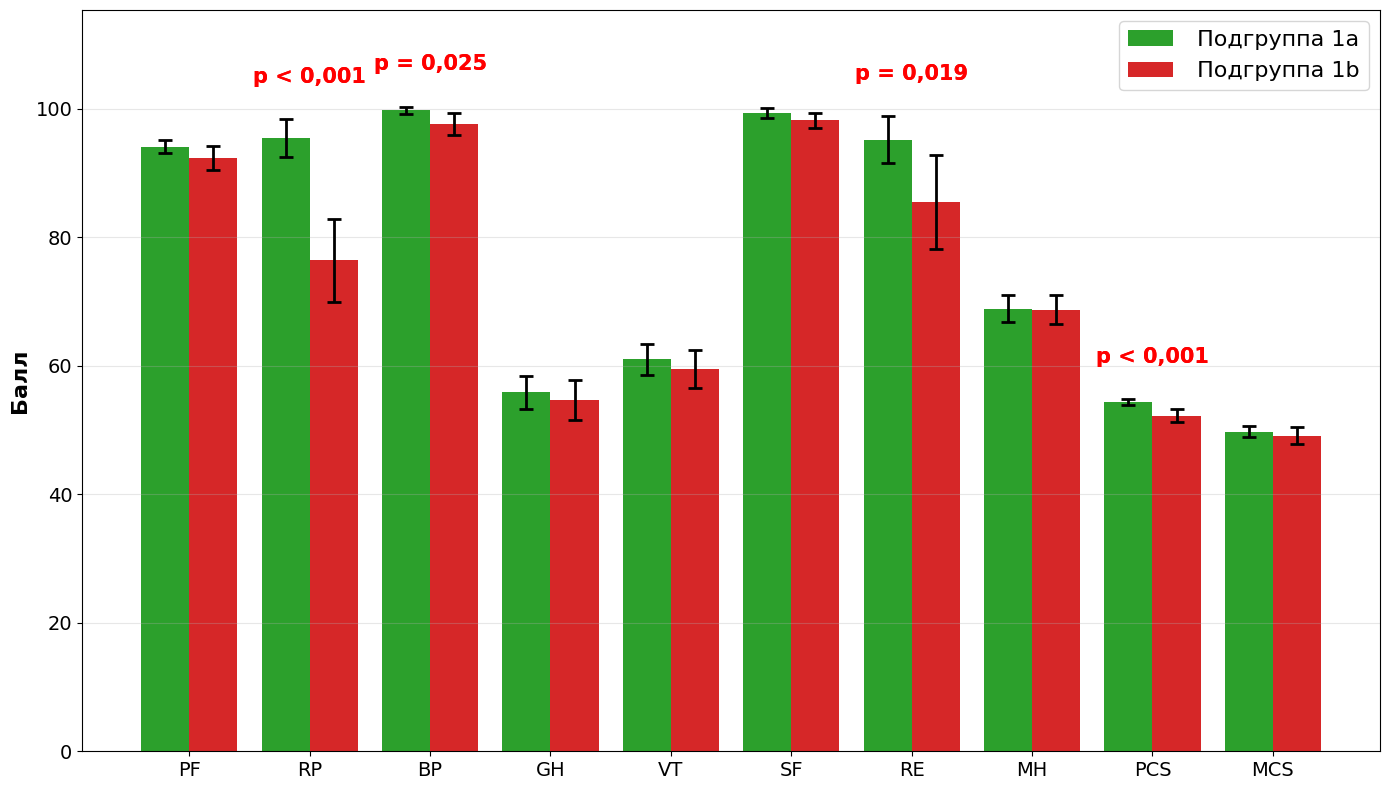

In [ ]:
# Укажите путь к вашему файлу
file_path = "Для диаграмм с усами.xlsx"
sheet_name = "А9"

#try:
# Запуск анализа
results = analyze_clinical_data(file_path, sheet_name)

# Создание сводной таблицы

#summary_table = create_summary_table(results, file_path, sheet_name)
#print("\nСводная таблица:")
#print(summary_table)

#except FileNotFoundError:
#    print(f"Файл {file_path} не найден!")
#except Exception as e:
#    print(f"Произошла ошибка: {e}")

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)